In [1]:
import pandas as pd

data = pd.read_csv('spotify-compressed.csv')

In [2]:
data.columns

Index(['Unnamed: 0', 'artistname', 'user', 'artist-value'], dtype='object')

In [3]:
data = data.drop('Unnamed: 0', axis=1)

In [4]:
# Oddly this didnt work so i wanted to select a row i knew had a blank value

import numpy as np
data_clean_df = data

data_clean_df['artistname'] = data['artistname'].replace(' ', np.nan)

data_clean_df = data_clean_df.dropna()

In [5]:
# Observing the weird value
print(data.iloc[3585])

artistname       
user            9
artist-value    1
Name: 3585, dtype: object


In [6]:
# Regex time, dropping any observations with only blank spaces
data_clean_df['artistname'] = data_clean_df['artistname'].replace(r'^\s*$', np.nan, regex=True)

data_clean_df = data_clean_df.dropna()

In [7]:
# Checking that it is gone
print(data_clean_df.iloc[3585])

artistname      The Limeliters
user                         9
artist-value                 3
Name: 3586, dtype: object


Values that would be dropped: 2,703,706
Users that would be dropped: 913


count    15914.000000
mean       206.458967
std        344.262166
min          1.000000
25%         33.000000
50%        110.000000
75%        265.000000
max      21966.000000
Name: user, dtype: float64

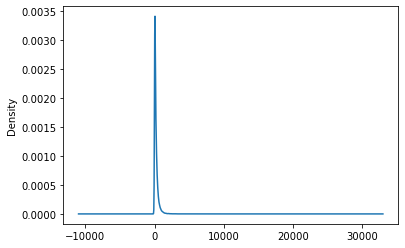

In [8]:
# I am experancing a memory issue still so i need to see what values I can drop
# Looking at what-if, if I were to drop users who listen to less than 1000 songs.
count_user = data_clean_df['user'].value_counts()

sum_counts_users = count_user[count_user < 1000].sum()
sum_counts_users1 = count_user[count_user < 1000].nunique()
print('Values that would be dropped: {:,}'.format(sum_counts_users))
print('Users that would be dropped: {:,}'.format(sum_counts_users1))

# Graph is what the data looks like before I drop any observations
# Stats displayed are what it would look like if I did drop observations
# Not very good practice to have things next to each other that use diffrent metrics, so I wanted to state this.
count_user.plot(kind='kde')
count_user.describe()

In [9]:
# For dropping users

# Creating the condition
mask = count_user[count_user >= 600].index

# Applying the condition
data_clean_df = data_clean_df[data_clean_df['user'].isin(mask)]


Values that would be dropped: 114,832
Artist that would be dropped: 24


count    194380.000000
mean          5.927153
std          24.977955
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max         814.000000
Name: artistname, dtype: float64

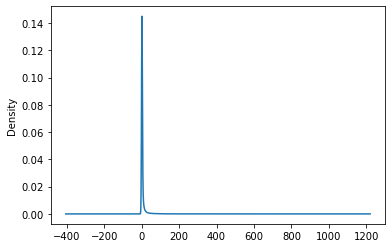

In [10]:
# I am experancing a memory issue so I need to see what values I can drop.
# We just dropped some users, now we are looking at artist.
# Since a lot are only observed 1 time I want to see the counts.
count = data_clean_df['artistname'].value_counts()

# Checks count of values under defined value
sum_counts = count[count <= 1].sum()  # Looking at artist count that is at or below once
sum_counts_artist = count[count < 25].nunique()  # Looking at artist observered less than 25 times
print('Values that would be dropped: {:,}'.format(sum_counts))
print('Artist that would be dropped: {:,}'.format(sum_counts_artist))
# look at distribution 
count.plot(kind='kde')
count.describe()

In [11]:
# I am trying to find a good cut off value to use for removing so many artist that I dont really need
# I have around 16,000 users and 289,820 artist
loop_list = [1000, 500, 200, 150, 100, 80, 50, 30, 20, 10, 5, 2]

total = data_clean_df.shape[0]

for i in loop_list:
    sum_counts = count[count >= i].sum()
    percent = sum_counts/total
    print('The observations seen above {} are {} of {}, or {} '.format(i, sum_counts,total, percent))

print('-----loop break-----')

for i in range(50, 101, 5):
    sum_counts = count[count >= i].sum()
    percent = sum_counts/total
    print('The observations seen above {} are {} of {}, or {} '.format(i, sum_counts,total, percent))

The observations seen above 1000 are 0 of 1152120, or 0.0 
The observations seen above 500 are 35126 of 1152120, or 0.030488143596153178 
The observations seen above 200 are 241486 of 1152120, or 0.20960143040655488 
The observations seen above 150 are 307650 of 1152120, or 0.26702947609623995 
The observations seen above 100 are 400288 of 1152120, or 0.3474360309689963 
The observations seen above 80 are 449172 of 1152120, or 0.3898656389959379 
The observations seen above 50 are 550717 of 1152120, or 0.47800315939311877 
The observations seen above 30 are 644156 of 1152120, or 0.5591049543450335 
The observations seen above 20 are 713886 of 1152120, or 0.6196281637329445 
The observations seen above 10 are 820359 of 1152120, or 0.7120430163524633 
The observations seen above 5 are 914895 of 1152120, or 0.7940969690657224 
The observations seen above 2 are 1037288 of 1152120, or 0.9003298267541575 
-----loop break-----
The observations seen above 50 are 550717 of 1152120, or 0.4780031

Values that would be dropped: 751,832


count    1900.000000
mean      210.677895
std       114.893272
min       100.000000
25%       124.000000
50%       173.000000
75%       259.250000
max       814.000000
Name: artistname, dtype: float64

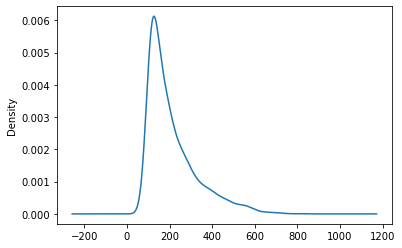

In [12]:

# Checks count of values under defined value that would be dropped
sum_counts1 = count[count < 100].sum()
print('Values that would be dropped: {:,}'.format(sum_counts1))

# look at distribution 
count1_stat = count[count >= 100]
count1_stat.plot(kind='kde')
count1_stat.describe()

# Lets roll with dropping artist that have only been observed less than 78 times.
# The std of the dataset is 78.84378, I am going to test out 78 because its as close to the,
# std of the dataset that I can get as these are int's. If this doesn't work I can go higher,
# however, I REALLY want to preserve as much data as I possible can.

In [13]:
# Creating the condition
mask = count[count >= 25].index

# Applying the condition
data_clean_filter_df = data_clean_df[data_clean_df['artistname'].isin(mask)]

In [14]:
# Creating the sparse matrix
sparse_df = data_clean_filter_df.pivot_table(index='artistname', columns='user', values='artist-value', fill_value=0)

In [15]:
# It looks like dropping artist below 78 listens helped, and we were able to create the sparse matrix in 9.7s.
# Lets see if I can tone that number down, dropping less, so that we can preserve the data.

# Creating the condition
mask = count[count >= 25].index

# Applying the condition
data_clean_filter_df = data_clean_df[data_clean_df['artistname'].isin(mask)]

# Creating the sparse matrix
sparse_df = data_clean_filter_df.pivot_table(index='artistname', columns='user', values='artist-value', fill_value=0)

# I was playing around with it, I could go lower down to 10-15
# However I still want it to be somewhat okay with the actual NMF calculations going forward.


In [16]:
# Looking for my new cut off target
for i in range(10, 26):
    sum_counts = count[count >= i].sum()
    percent = sum_counts/3285588
    print('The observations seen above {} are {} of {}, or {} '.format(i, sum_counts, total, percent))

The observations seen above 10 are 820359 of 1152120, or 0.2496840748140059 
The observations seen above 11 are 806359 of 1152120, or 0.2454230414768985 
The observations seen above 12 are 793423 of 1152120, or 0.24148584667341128 
The observations seen above 13 are 781399 of 1152120, or 0.2378262277558842 
The observations seen above 14 are 769829 of 1152120, or 0.234304788062289 
The observations seen above 15 are 759455 of 1152120, or 0.23114736235949243 
The observations seen above 16 are 749300 of 1152120, or 0.22805659139246917 
The observations seen above 17 are 739796 of 1152120, or 0.2251639584756214 
The observations seen above 18 are 730548 of 1152120, or 0.2223492415969379 
The observations seen above 19 are 722664 of 1152120, or 0.21994967110909827 
The observations seen above 20 are 713886 of 1152120, or 0.21727800320673193 
The observations seen above 21 are 705426 of 1152120, or 0.21470312163302277 
The observations seen above 22 are 696753 of 1152120, or 0.212063411480

In [17]:
# Rolling out the new condition and exporting the sparse matrix
# The observations seen above 15 are 2670232 of 3285588, or 0.8127105407007817
# Lets go with the cut-off of 15, that means we were still about to preserve 81.27% of the data.

# Creating the condition
mask = count[count >= 25].index

# Applying the condition
data_clean_filter_df = data_clean_df[data_clean_df['artistname'].isin(mask)]

# Creating the sparse matrix
sparse_df = data_clean_filter_df.pivot_table(index='artistname', columns='user', values='artist-value', fill_value=0)

# Exporting
sparse_df.to_csv('spotify-sparse.csv')

In [154]:
sparse_df.to_csv('spotify-sparse5.csv')

#### For Testing
This is for adjusting the sparse matrix so I can find what works best. You have to run the first few cells first before coming here. Also to reset, you have to re-run the first few cells. Afterwards, you can come here and re-run the conditions. Note that you have to run the cell TWICE as you have to run conditions again after you did another condition. ie. user will affect artist and because artist is affected, user will be as well. So re-run twice.

In [19]:
# Machine spec: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz
# 8 CPU Cores, cores were clocked during training time at 4.20GHz on average.

# (596, 364) working, at >= 1000 user 100 artist, time: 0mins 25.7sec, saved as sparse
# (4823, 463) working, at >= 900 user 25 artist, time: 4mins 19.6sec, saved as sparse1
# (2173, 463) working, at >= 900 user 50 artist, time: 2min 2.2sec, saved as sparse2
# (5231, 536) working, at >= 850 user 25 artist, time: 6min 18.9sec, saved as sparse3
# (6094, 707) working, at >= 750 user 25 artist, time: 12min 46.7sec, saved as sparse4
# (7703, 1121) working, at >= 600 user 25 artist, time: 40min 11.4sec, saved as sparse5

# Adjustable values, selects X that has >= Y number of observations in the dataframe
user_adjust = 600
artist_adjust = 25

# Gathering variables
count_user = data_clean_df['user'].value_counts()
count = data_clean_df['artistname'].value_counts()

# For user drop
# Creating the condition
mask = count_user[count_user >= user_adjust].index
# Applying the condition
data_clean_df = data_clean_df[data_clean_df['user'].isin(mask)]


# For artist drop
# Creating the condition
mask = count[count >= artist_adjust].index
# Applying the condition
data_clean_filter_df = data_clean_df[data_clean_df['artistname'].isin(mask)]


# Creating the sparse matrix
sparse_df = data_clean_filter_df.pivot_table(index='artistname', columns='user', values='artist-value', fill_value=0)